These are what I did:
      - Use different weights for the content and style layers.
      - Use several style images.
      - Try using other layers in the model. 

In [28]:
import os
from libs import utils

content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
    os.makedirs(checkpoint_directory)
    
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'rain-princess.jpg')
style_path2 = os.path.join(style_directory, 'starry-night.jpg')
style_path3 = os.path.join(style_directory, 'the-scream.jpg')
#output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')

# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [22]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]

In [3]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)
def net_preloaded(input_image, pooling):
    data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels = get_conv_filter(data_dict, name)
            bias = get_bias(data_dict, name)
            
            current = conv_layer(current, kernels, bias)
            
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = pool_layer(current, pooling)
            
        net[name] = current
        
    assert len(net) == len(VGG19_LAYERS)
    return net

def conv_layer(input_, weights, bias):
    conv = tf.nn.conv2d(input_, weights, strides=(1,1,1,1), padding='SAME')
    return tf.nn.bias_add(conv, bias)

def pool_layer(input_, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input_, ksize=(1,2,2,1), strides=(1,2,2,1), 
                              padding='SAME')
    else:
        return tf.nn.max_pool(input_, ksize=(1,2,2,1), strdies=(1,2,2,1), 
                              padding='SAME')
    
def get_conv_filter(data_dict, name):
    return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
    return tf.constant(data_dict[name][1], name="biases")

def preprocess(image):
    return image - VGG_MEAN

def unprocess(image):
    return image + VGG_MEAN

In [51]:
from functools import reduce 
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

In [52]:
def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat',
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2,
            style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
            learning_rate=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    shape = (1,) + content.shape
    style_shapes = [(1,) + style.shape for style in styles]
    
    content_features = {}
    style_features = [{} for _ in styles]
    
    layer_weight = 1.0
    style_layers_weights = {}
    
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = layer_weight
        layer_weight *= style_layer_weight_exp
        
    layer_weights_sum = 0
    for style_layer in STYLE_LAYERS:
        layer_weights_sum += style_layers_weights[style_layer]
        
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] /= layer_weights_sum
        
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
        image = tf.placeholder('float', shape=shape)
        net = net_preloaded(image, pooling)
        
        content_pre = np.array([preprocess(content)])
        
        for layer in CONTENT_LAYERS:
            content_features[layer] = net[layer].eval(feed_dict={image: content_pre})
            
    for i in range(len(styles)):
        g = tf.Graph()
        with g.as_default(), tf.Session() as sess:
            image = tf.placeholder('float', shape=style_shapes[i])
            net = net_preloaded(image, pooling)
            style_pre = np.array([preprocess(styles[i])])
            for layer in STYLE_LAYERS:
                features = net[layer].eval(feed_dict={image: style_pre})
                features = np.reshape(features, (-1, features.shape[3]))
                gram = np.matmul(features.T, features) / features.size
                style_features[i][layer] = gram
    
    # make stylized image using backpropogation
    with tf.Graph().as_default():
        initial = tf.random_normal(shape) * 0.256
        image = tf.Variable(initial)
        net = net_preloaded(image, pooling)
        
        # CONTENT LOSS
        # Adjust the weight of each content layers
        # content_weight_blend is the ratio of two used content layers in the example
        content_layers_weights = {}
        content_layers_weights['relu4_2'] = content_weight_blend
        content_layers_weights['relu5_2'] = 1.0 - content_weight_blend
        
        content_loss = 0
        content_losses = []
        
        for content_layer in CONTENT_LAYERS:
            # USE MSE as CONTENT LOSS
            content_losses.append(content_layers_weights[content_layer] * content_weight * 
                                  (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) / 
                                   content_features[content_layer].size))
        
        content_loss += reduce(tf.add, content_losses)
        if style_blend_weights is None:
            style_blend_weights = [1.0/len(style_images) for _ in style_images]
        else:
            total_blend_weight = sum(style_blend_weights)
            # normalize
            style_blend_weights = [weight/total_blend_weight for weight in style_blend_weights]
            
        
        style_loss = 0
        
        # iterate to calculate style loss with multiple style images
        for i in range(len(styles)):
            style_losses = []
            for style_layer in STYLE_LAYERS:
                layer = net[style_layer]
                
                _, height, width, number = map(lambda i: i.value, layer.get_shape())
                size = height * width * number
                feats = tf.reshape(layer, (-1, number))
                
                gram = tf.matmul(tf.transpose(feats), feats) / size
                style_gram = style_features[i][style_layer]
                
                style_losses.append(style_layers_weights[style_layer] * 2 * 
                                    tf.nn.l2_loss(gram - style_gram) / style_gram.size)
                
            style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)
            
            
        tv_y_size = _tensor_size(image[:, 1:, :, :])
        tv_x_size = _tensor_size(image[:, :, 1:, :])
        tv_loss = tv_weight * 2 * (
            (tf.nn.l2_loss(image[:, 1:, :, :] - image[:, :shape[1]-1, :, :]) / tv_y_size) +
            (tf.nn.l2_loss(image[:, :, 1:, :] - image[:, :, :shape[2]-1, :]) / tv_x_size)
        )
        
        loss = content_loss + style_loss + tv_loss
        
        train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)
        
        def print_progress():
            print('     iteration: %d\n' % i)
            print('  content loss: %g\n' % content_loss.eval())
            print('    style loss: %g\n' % style_loss.eval())
            print('       tv loss: %g\n' % tv_loss.eval())
            print('    total loss: %g\n' % loss.eval())
            
        def imsave(path, img):
            img = np.clip(img, 0, 255).astype(np.uint8)
            Image.fromarray(img).save(path, quality=95)
            
            
        best_loss = float('inf')
        best = None
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            if (print_iterations and print_iterations != 0):
                print_progress()
                
            for i in range(iterations):
                train_step.run()
                
                last_step = (i == iterations - 1)
                
                if last_step or (print_iterations and i % print_iterations == 0):
                    print_progress()
                    
                if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                    this_loss = loss.eval()
                    if this_loss < best_loss:
                        best_loss = this_loss
                        best = image.eval()
                        
                    img_out = unprocess(best.reshape(shape[1:]))
                    output_file = None
                    
                    if not last_step:
                        if checkpoint_path:
                            output_file = checkpoint_path % i
                        
                    else:
                        output_file = output_path
                    
                    if output_file:
                        imsave(output_file, img_out)
                        
    print("finish stylizing.")

def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

## Original Picture

In [11]:
from IPython.display import Image

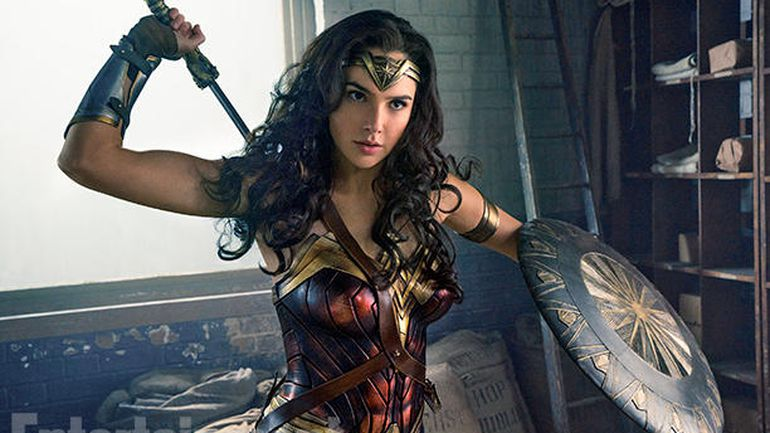

In [12]:
Image('./contents/wonder-woman.jpg')

## Test Lab Output

In [7]:
from PIL import Image
checkpoint_path=None
output_path='./image_output/wonder-woman-rain_princess-tvweight-100.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383693

    style loss: 1.07149e+07

       tv loss: 26.2188

    total loss: 1.10987e+07

     iteration: 0

  content loss: 370790

    style loss: 1.00368e+07

       tv loss: 15038.9

    total loss: 1.04226e+07

     iteration: 100

  content loss: 321096

    style loss: 105091

       tv loss: 56524.6

    total loss: 482711

     iteration: 200

  content loss: 263195

    style loss: 55758.1

       tv loss: 48450.1

    total loss: 367403

     iteration: 300

  content loss: 252939

    style loss: 95277.9

       tv loss: 46165.6

    total loss: 394383

     iteration: 400

  content loss: 233704

    style loss: 42931.8

       tv loss: 43502.3

    total loss: 320138

     iteration: 500

  content loss: 225538

    style loss: 61398.7

       tv loss: 43113

    total loss: 330049

     iteration: 600

  content loss: 220833

    style loss: 73890.4

       tv loss: 41626.9

    total loss: 336350

     iteration: 700

  content loss: 

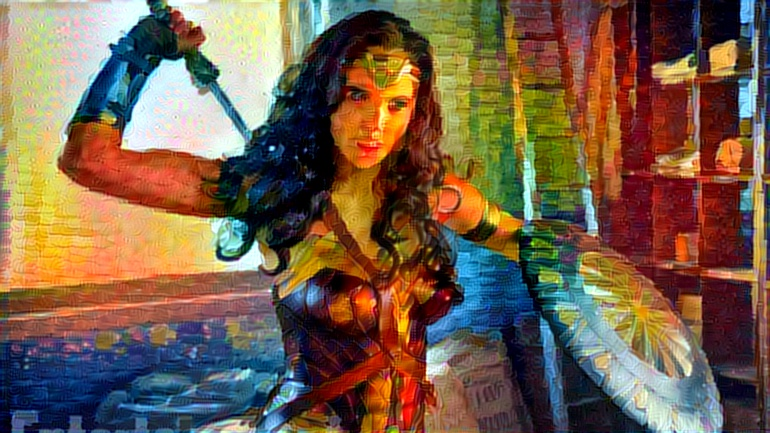

In [13]:
from IPython.display import Image
Image('./image_output/wonder-woman-rain_princess-tvweight-100.jpg')

## 1. Use different weights for the content and style layers.

首先，我先試著改動 content_weight 和 style_weight，將它們調成一樣，看看結果會如何。

In [14]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-rain_princess-100.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e1, content_weight_blend=1, style_weight=5e1, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 3.83679e+06

    style loss: 1.07149e+06

       tv loss: 26.1301

    total loss: 4.90831e+06

     iteration: 0

  content loss: 3.65748e+06

    style loss: 1.01437e+06

       tv loss: 16086.7

    total loss: 4.68793e+06

     iteration: 100

  content loss: 299488

    style loss: 348205

       tv loss: 76271.8

    total loss: 723964

     iteration: 200

  content loss: 241250

    style loss: 320550

       tv loss: 60364.7

    total loss: 622165

     iteration: 300

  content loss: 215789

    style loss: 314630

       tv loss: 55970.9

    total loss: 586391

     iteration: 400

  content loss: 186915

    style loss: 313616

       tv loss: 51014.9

    total loss: 551547

     iteration: 500

  content loss: 193945

    style loss: 312076

       tv loss: 49368.8

    total loss: 555390

     iteration: 600

  content loss: 190653

    style loss: 312571

       tv loss: 48289.1

    total loss: 551513

     iteration: 700

  content

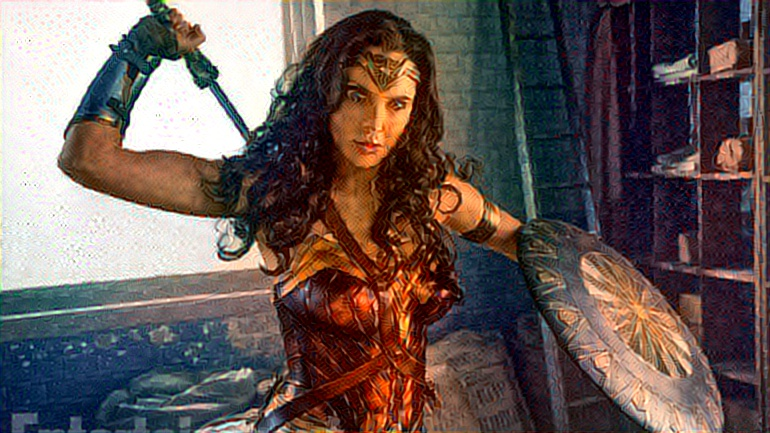

In [16]:
from IPython.display import Image
Image('./image_output/wonder-woman-rain_princess-100.jpg')

可以發現，由於我們提高了原圖的 weight 並降低了 style 的 weight，所以 style 的效果降低的滿明顯的，不過在整體上還是有將原圖的色調提升，尤其是盔甲的部分。  
此外，也能發現，原圖中的人變得比較明顯，我認為應該是因為如同 lab 中提到的，人體附近會有較大的 gradient，所以人的 feature 會比較重要。因此，提高 content image 的權重以後，相對於之前，人會更明顯的凸顯出來。

In [17]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-rain_princess-3000.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e1, content_weight_blend=1, style_weight=5e1, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=3000,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 3.83723e+06

    style loss: 1.07149e+06

       tv loss: 788.369

    total loss: 4.90952e+06

     iteration: 0

  content loss: 3.65508e+06

    style loss: 1.01435e+06

       tv loss: 485133

    total loss: 5.15456e+06

     iteration: 100

  content loss: 403513

    style loss: 449819

       tv loss: 257584

    total loss: 1.11092e+06

     iteration: 200

  content loss: 331681

    style loss: 411419

       tv loss: 231472

    total loss: 974572

     iteration: 300

  content loss: 301678

    style loss: 410546

       tv loss: 219573

    total loss: 931797

     iteration: 400

  content loss: 283679

    style loss: 414691

       tv loss: 216256

    total loss: 914626

     iteration: 500

  content loss: 276206

    style loss: 416043

       tv loss: 209657

    total loss: 901906

     iteration: 600

  content loss: 272505

    style loss: 415879

       tv loss: 216844

    total loss: 905229

     iteration: 700

  content l

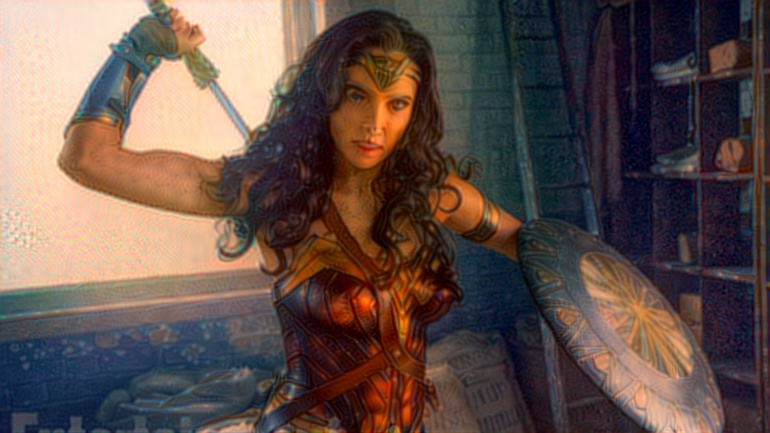

In [18]:
from IPython.display import Image
Image('./image_output/wonder-woman-rain_princess-3000.jpg')

此外，我還嘗試改變tv_weight。  
從圖形看來，提高 tv_weight 的效果在於能夠提高 tv_loss，進而讓整體圖片更加清晰，減少 noise 的影響。

## 2. Use several style images.

首先，我先試著用兩個 style contents，分別是原本的 rain princess 和 starry night，style_blend_weight 各占一半。

### 0.5 rain princess + 0.5 starry night

In [24]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path), utils.imread(style_path2)]
print('#Style Images: %d' % len(style_images))

#Style Images: 2


In [25]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-rain-starry.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.5, 0.5], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 1

  content loss: 383719

    style loss: 6.11568e+06

       tv loss: 26.1815

    total loss: 6.49942e+06

     iteration: 0

  content loss: 369243

    style loss: 5.66461e+06

       tv loss: 15309.6

    total loss: 6.04916e+06

     iteration: 100

  content loss: 161204

    style loss: 1.41161e+06

       tv loss: 43091.5

    total loss: 1.6159e+06

     iteration: 200

  content loss: 127283

    style loss: 1.41735e+06

       tv loss: 37214.3

    total loss: 1.58185e+06

     iteration: 300

  content loss: 125144

    style loss: 1.39932e+06

       tv loss: 35498.3

    total loss: 1.55997e+06

     iteration: 400

  content loss: 116944

    style loss: 1.39709e+06

       tv loss: 34277.2

    total loss: 1.54832e+06

     iteration: 500

  content loss: 111324

    style loss: 1.40524e+06

       tv loss: 34487.6

    total loss: 1.55105e+06

     iteration: 600

  content loss: 116698

    style loss: 1.39804e+06

       tv loss: 33457.1

    total 

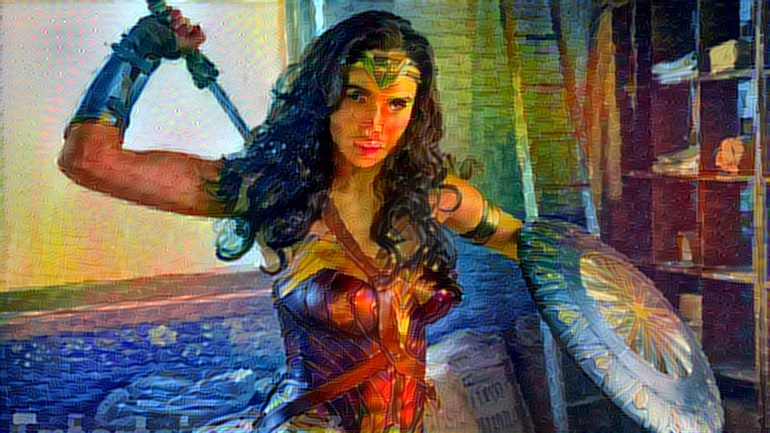

In [27]:
from IPython.display import Image
Image('./image_output/wonder-woman-rain-starry.jpg')

可以看到，由於 starry night 和 rain princess 比例差不多，所以兩者的份量不會差很多。  
比起只用 rain princess，多了許多 starry night 的 style，尤其背景部分更為明顯，增加了 starry night 的藍色色調。
再來我們試著改動 style_blend_weight 看看，分別調成 0.3、0.7

### 0.3 rain princess + 0.7 starry night

In [30]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-0.3rain-0.7starry.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.3, 0.7], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 1

  content loss: 383706

    style loss: 2.68541e+06

       tv loss: 26.1387

    total loss: 3.06914e+06

     iteration: 0

  content loss: 368285

    style loss: 2.46765e+06

       tv loss: 15692.5

    total loss: 2.85163e+06

     iteration: 100

  content loss: 107086

    style loss: 501357

       tv loss: 12051.1

    total loss: 620494

     iteration: 200

  content loss: 88464.7

    style loss: 495225

       tv loss: 10290.8

    total loss: 593980

     iteration: 300

  content loss: 81704.3

    style loss: 479495

       tv loss: 9518.81

    total loss: 570718

     iteration: 400

  content loss: 108901

    style loss: 511941

       tv loss: 13050.4

    total loss: 633892

     iteration: 500

  content loss: 75716.9

    style loss: 477471

       tv loss: 9164.04

    total loss: 562352

     iteration: 600

  content loss: 79160.5

    style loss: 485752

       tv loss: 9579.29

    total loss: 574492

     iteration: 700

  content loss:

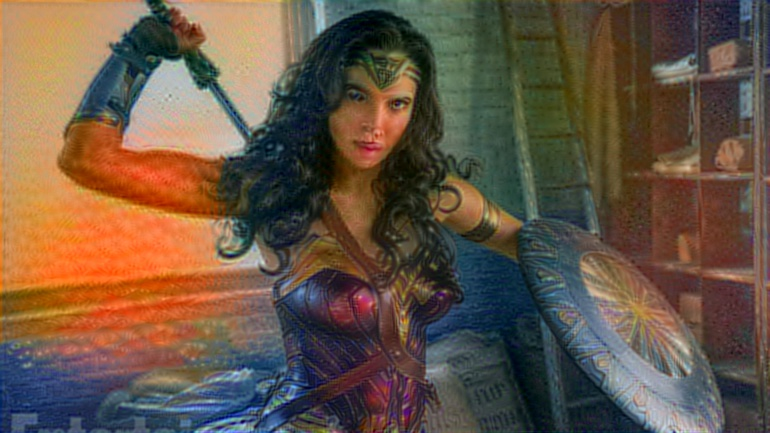

In [32]:
from IPython.display import Image
Image('./image_output/wonder-woman-0.3rain-0.7starry.jpg')

### 可以感覺得明顯比較接近 starry night 的 style，只有一部份的 rain princess 比較明顯。

### 0.7 rain princess + 0.3 starry night

In [34]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-0.7rain-0.3starry.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.7, 0.3], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 1

  content loss: 383711

    style loss: 2.0174e+06

       tv loss: 26.1675

    total loss: 2.40114e+06

     iteration: 0

  content loss: 367177

    style loss: 1.78774e+06

       tv loss: 15706.2

    total loss: 2.17062e+06

     iteration: 100

  content loss: 77721

    style loss: 480178

       tv loss: 22388.7

    total loss: 580288

     iteration: 200

  content loss: 71038.8

    style loss: 479907

       tv loss: 19836.2

    total loss: 570782

     iteration: 300

  content loss: 69812.1

    style loss: 479855

       tv loss: 19369.7

    total loss: 569036

     iteration: 400

  content loss: 63718.9

    style loss: 476893

       tv loss: 19189.5

    total loss: 559802

     iteration: 500

  content loss: 64998

    style loss: 478302

       tv loss: 19377.2

    total loss: 562677

     iteration: 600

  content loss: 63478

    style loss: 478003

       tv loss: 19331.7

    total loss: 560812

     iteration: 700

  content loss: 6044

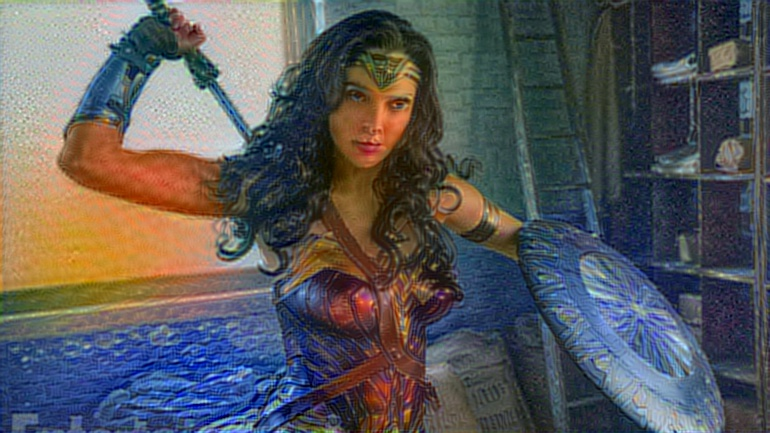

In [35]:
from IPython.display import Image
Image('./image_output/wonder-woman-0.7rain-0.3starry.jpg')

可以看到，雖然背景部分還是有 starry night style，但畫面整體而言還是比較接近 rain princess style

接著試試看 starry night 和 the scream，以及 the scream 加上 rain princess，兩個 style 的 weights 都固定為一半一半。

### 0.5 starry night + 0.5 the scream

In [36]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path2), utils.imread(style_path3)]
print('#Style Images: %d' % len(style_images))

#Style Images: 2


In [37]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-starry-scream.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.5, 0.5], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 1

  content loss: 383716

    style loss: 2.35141e+06

       tv loss: 26.157

    total loss: 2.73515e+06

     iteration: 0

  content loss: 367547

    style loss: 2.12701e+06

       tv loss: 15680.4

    total loss: 2.51023e+06

     iteration: 100

  content loss: 86078.5

    style loss: 572238

       tv loss: 16987.2

    total loss: 675304

     iteration: 200

  content loss: 71623.6

    style loss: 564228

       tv loss: 14717.4

    total loss: 650569

     iteration: 300

  content loss: 67621.4

    style loss: 564719

       tv loss: 14137.4

    total loss: 646478

     iteration: 400

  content loss: 71398.8

    style loss: 566805

       tv loss: 14804.5

    total loss: 653008

     iteration: 500

  content loss: 67494.2

    style loss: 561042

       tv loss: 13757.3

    total loss: 642293

     iteration: 600

  content loss: 73276

    style loss: 564979

       tv loss: 14153.4

    total loss: 652408

     iteration: 700

  content loss: 

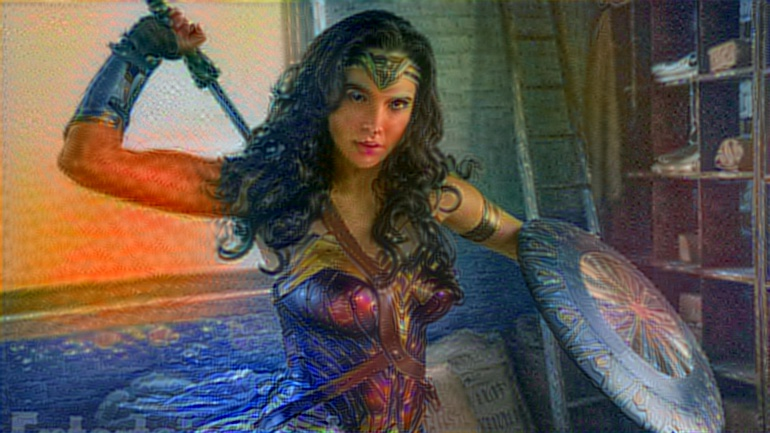

In [38]:
from IPython.display import Image
Image('./image_output/wonder-woman-starry-scream.jpg')

結果和 rain princess + starry night 相似，差別主要是色調而已。

### 0.5 the scream + 0.5 rain princess

In [40]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path), utils.imread(style_path3)]
print('#Style Images: %d' % len(style_images))

#Style Images: 2


In [41]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-rain-scream.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.5, 0.5], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)


     iteration: 1

  content loss: 383726

    style loss: 6.95069e+06

       tv loss: 26.1962

    total loss: 7.33444e+06

     iteration: 0

  content loss: 369610

    style loss: 6.51031e+06

       tv loss: 15222.4

    total loss: 6.89514e+06

     iteration: 100

  content loss: 170032

    style loss: 1.2212e+06

       tv loss: 26570.3

    total loss: 1.4178e+06

     iteration: 200

  content loss: 152296

    style loss: 1.18796e+06

       tv loss: 23556.4

    total loss: 1.36381e+06

     iteration: 300

  content loss: 135485

    style loss: 1.18552e+06

       tv loss: 21937.6

    total loss: 1.34294e+06

     iteration: 400

  content loss: 130472

    style loss: 1.17971e+06

       tv loss: 21214.5

    total loss: 1.3314e+06

     iteration: 500

  content loss: 134655

    style loss: 1.18465e+06

       tv loss: 21959.8

    total loss: 1.34126e+06

     iteration: 600

  content loss: 124358

    style loss: 1.18534e+06

       tv loss: 20917.8

    total lo

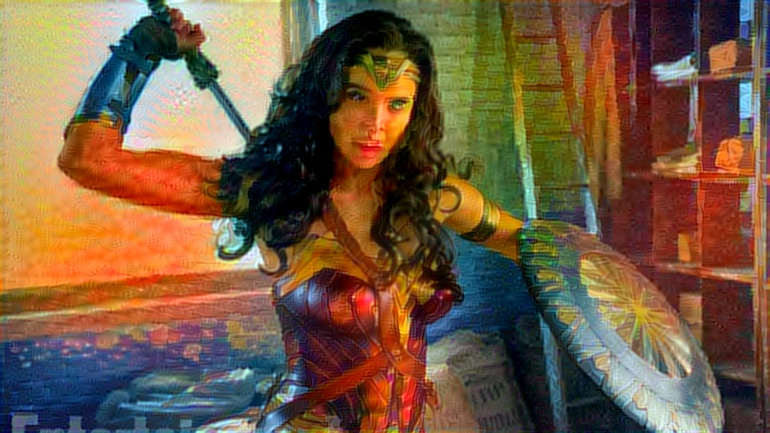

In [42]:
from IPython.display import Image
Image('./image_output/wonder-woman-rain-scream.jpg')

最後，我們三張圖─rain princess、starry night 和 the scream─分別用 0.3、0.4、0.3 的 weights 混合。

### 0.3 rain princess + 0.4 starry night + 0.3 the scream

In [43]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path), utils.imread(style_path2), utils.imread(style_path3)]
print('#Style Images: %d' % len(style_images))

#Style Images: 3


In [44]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-mix-all.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.3, 0.4, 0.3], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 2

  content loss: 383735

    style loss: 4.77698e+06

       tv loss: 26.2029

    total loss: 5.16074e+06

     iteration: 0

  content loss: 368523

    style loss: 4.41943e+06

       tv loss: 15339.3

    total loss: 4.80329e+06

     iteration: 100

  content loss: 115796

    style loss: 1.36676e+06

       tv loss: 28744.2

    total loss: 1.5113e+06

     iteration: 200

  content loss: 91796

    style loss: 1.3575e+06

       tv loss: 24132.3

    total loss: 1.47342e+06

     iteration: 300

  content loss: 91830.7

    style loss: 1.35272e+06

       tv loss: 23238.5

    total loss: 1.46779e+06

     iteration: 400

  content loss: 87027

    style loss: 1.35722e+06

       tv loss: 23182

    total loss: 1.46743e+06

     iteration: 500

  content loss: 87570

    style loss: 1.35462e+06

       tv loss: 22716.2

    total loss: 1.46491e+06

     iteration: 600

  content loss: 81545

    style loss: 1.35496e+06

       tv loss: 22264.7

    total loss: 

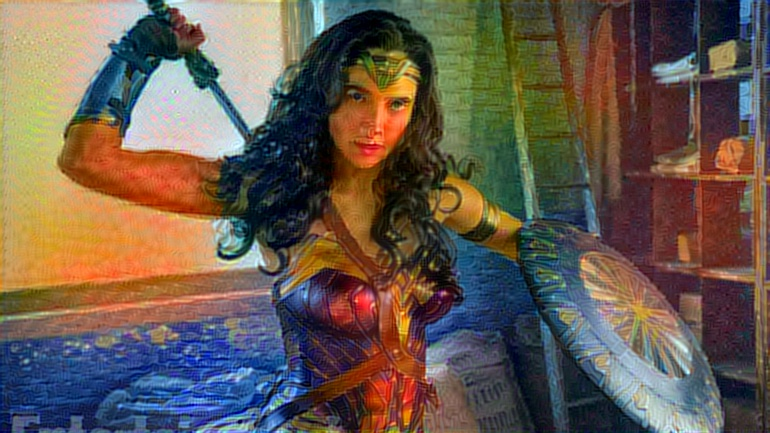

In [49]:
from IPython.display import Image
Image('./image_output/wonder-woman-mix-all.jpg')

可以在背景的部份看到明顯的 starry night 和 the scream style。

## 3. Try using other layers in the model. 

在最後這部分，我試著將 style 的 layer 換成經過 pooling 後的結果。

In [53]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]
print('#Style Images: %d' % len(style_images))

#Style Images: 1


In [54]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('pool1', 'pool2', 'pool3', 'pool4', 'relu5_4')

In [55]:
from PIL import Image
checkpoint_path=None
output_path='image_output/wonder-woman-change_layer.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=[0.3, 0.4, 0.3], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 383710

    style loss: 6.49016e+07

       tv loss: 26.1857

    total loss: 6.52853e+07

     iteration: 0

  content loss: 374671

    style loss: 6.08946e+07

       tv loss: 13428.3

    total loss: 6.12827e+07

     iteration: 100

  content loss: 512773

    style loss: 730619

       tv loss: 96186.7

    total loss: 1.33958e+06

     iteration: 200

  content loss: 411934

    style loss: 256435

       tv loss: 76038.9

    total loss: 744408

     iteration: 300

  content loss: 348194

    style loss: 119327

       tv loss: 65131.7

    total loss: 532652

     iteration: 400

  content loss: 309964

    style loss: 72796.3

       tv loss: 58628.8

    total loss: 441389

     iteration: 500

  content loss: 289699

    style loss: 50067.4

       tv loss: 55404.5

    total loss: 395171

     iteration: 600

  content loss: 276154

    style loss: 60888.4

       tv loss: 54282

    total loss: 391325

     iteration: 700

  content los

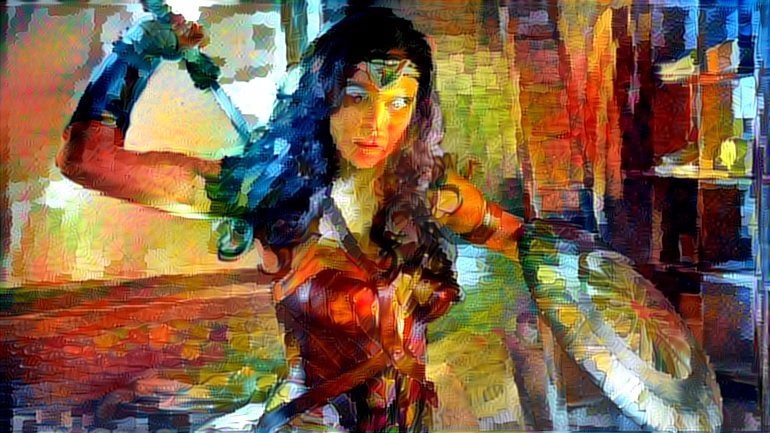

In [56]:
from IPython.display import Image
Image('./image_output/wonder-woman-change_layer.jpg')

可以發現，style 的效果更為明顯。